![](https://storage.googleapis.com/kaggle-public-downloads/arXiv.JPG)
<h1><center>Research Paper Title Generation</center></h1>

## Introduction

#### In this notebook, we use [BART](https://arxiv.org/abs/1910.13461) Transformer model to perform title generation from abstracts. BART is a sequence-to-sequence model where both the input and targets are text sequences. BART is commonly used for text summarization. In our case, we would want to summarize titles from abstracts.

### Acknowledgements

#### This notebook borrows code from:
* [simpletransformers documentation](https://github.com/ThilinaRajapakse/simpletransformers)
* Andrew Lukyanenko's [Arxiv metadata exploration](https://www.kaggle.com/artgor/arxiv-metadata-exploration) kernel

### Libraries 📚⬇

In [1]:
%%time

!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip uninstall -q tqdm -y > /dev/null
!pip install -q tqdm==4.48.1 > /dev/null
!pip uninstall -q torch -y > /dev/null
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null

     |████████████████████████████████| 2.1 MB 6.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
allennlp 1.0.0 requires transformers<2.12,>=2.9, but you have transformers 3.0.2 which is incompatible.
CPU times: user 1.7 s, sys: 437 ms, total: 2.14 s
Wall time: 1min 50s


In [2]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
# from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [3]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu101', '3.0.2', '0.8.1.rc1')

### Read JSON Data 📝

In [4]:
data_file = '../input/arxiv/arxiv-metadata-oai-snapshot.json'

""" Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

#### Let's print a sample paper metadata

In [5]:
metadata = get_metadata()
for paper in metadata:
    for k, v in json.loads(paper).items():
        print(f'{k}: {v} \n')
    break

id: 0704.0001 

submitter: Pavel Nadolsky 

authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan 

title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies 

comments: 37 pages, 15 figures; published version 

journal-ref: Phys.Rev.D76:013009,2007 

doi: 10.1103/PhysRevD.76.013009 

report-no: ANL-HEP-PR-07-12 

categories: hep-ph 

license: None 

abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
m

In [6]:
category_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

# #1. Abstract Summarization
###    Title Prediction from Abstract using **BART**

#### For this task, let's choose all paper categories published in the last decade

In [7]:
titles = []
abstracts = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(category_map.keys())).flatten()

# # Consider specific paper categories to be used during training and prediction
# paper_categories = ["cs.AI", # Artificial Intelligence
#                     "cs.CV", # Computer Vision and Pattern Recognition
#                     "cs.LG"] # Machine Learning

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    try:
        year = int(paper_dict.get('journal-ref')[-4:])
        if category in paper_categories and 2010<year<2021:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract').replace("\n",""))
    except:
        pass 

len(titles), len(abstracts)

(21592, 21592)

### #1.2 Data Pre-processing ⚙️

In [8]:
papers = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
})

papers = papers[['abstract', 'title']]
papers.columns = ['input_text', 'target_text']
papers = papers.dropna()

del titles, abstracts
papers

,input_text,target_text
0,We present in this article a detailed quanti...,A unified analysis of the reactor neutrino pro...
1,The aim of the KArlsruhe TRItium Neutrino ex...,The KATRIN sensitivity to the neutrino mass an...
2,"In this letter, we propose three different s...","Penguin-mediated B_(d,s)->VV decays and the Bs..."
3,We find non-supersymmetric metastable vacua ...,Non Supersymmetric Metastable Vacua in N=2 SYM...
4,We show how to test whether a graph with n v...,Recognizing Partial Cubes in Quadratic Time
...,...,...
21587,"Schroedinger (Nature, v.169, p.538 (1952)) d...",Real-Valued Charged Fields and Interpretation ...
21588,"Given a collection of states (rho_1, ..., rh...",How many copies are needed for state discrimin...
21589,"Hu, Paz and Zhang [ B.L. Hu, J.P. Paz and Y....",Alternative Derivation of the Hu-Paz-Zhang Mas...
21590,We demonstrate guiding of cold neutral atoms...,Guiding Neutral Atoms with a Wire


### #1.3 Model Training & Evaluation 🚞

In [9]:
%%time

from simpletransformers.seq2seq import Seq2SeqModel

eval_df = papers.sample(frac=0.1, random_state=42)
train_df = papers.drop(eval_df.index)

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 6,
    "num_train_epochs": 3,
}

# Create a Bart-base model
model = Seq2SeqModel(encoder_decoder_type="bart",
                    encoder_decoder_name="facebook/bart-base",
                    args=model_args)


CPU times: user 17 s, sys: 1.94 s, total: 18.9 s
Wall time: 20.5 s


In [10]:
%%time

# Train the model
model.train_model(train_df)

# Evaluate the model
result = model.eval_model(eval_df)
print(result)


{'eval_loss': 2.202055701061531}
CPU times: user 2h 10min 31s, sys: 1min 40s, total: 2h 12min 11s
Wall time: 1h 41min 29s


In [15]:
# Save the trained model to the directory 'trained_model' in Kaggle environment
model.model.save_pretrained("/kaggle/working/trained_model")


In [20]:
from transformers import BartTokenizer

# Create and save the tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
tokenizer.save_pretrained("/kaggle/working/trained_model")
from simpletransformers.seq2seq import Seq2SeqModel

# Assuming you have the model instance `model` already trained
model.model.save_pretrained("/kaggle/working/trained_model")


In [21]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the saved model and tokenizer
model = BartForConditionalGeneration.from_pretrained("/kaggle/working/trained_model")
tokenizer = BartTokenizer.from_pretrained("/kaggle/working/trained_model")

# Now you can use the model and tokenizer for inference
input_text = " We demonstrate the capability of accurate time transfer using optical fibersover long distances utilizing a dark fiber and hardware which is usuallyemployed in two-way satellite time and frequency transfer (TWSTFT). Our timetransfer through optical fiber (TTTOF) system is a variant of the standardTWSTFT by employing an optical fiber in the transmission path instead offree-space transmission of signals between two ground stations throughgeostationary satellites."
inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=150, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(summary)


 Time Transfer Using Optical Fibers over Long Distance


### #1.4 Prediction 🔮

In [24]:
for _ in range(250):
    random_idx = random.randint(0, len(eval_df) - 1)

    abstract = eval_df.iloc[random_idx]['input_text']
    true_title = eval_df.iloc[random_idx]['target_text']

    # Tokenize the abstract
    inputs = tokenizer(abstract, return_tensors="pt", max_length=512, truncation=True)
    
    # Predict with trained BART model
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=150, early_stopping=True)
    predicted_title = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f'True Title: {true_title}\n')
    print(f'Predicted Title: {predicted_title}\n')
    print(f'Abstract: {abstract}\n\n\n')

True Title: A First Approach on Modelling Staff Proactiveness in Retail Simulation
  Models

Predicted Title:  Impact of Proactivity on the Output Accuracy of Simulation Models of
  Human Centric Systems

Abstract:   There has been a noticeable shift in the relative composition of the industryin the developed countries in recent years; manufacturing is decreasing whilethe service sector is becoming more important. However, currently mostsimulation models for investigating service systems are still built in the sameway as manufacturing simulation models, using a process-oriented world view,i.e. they model the flow of passive entities through a system. These kinds ofmodels allow studying aspects of operational management but are not well suitedfor studying the dynamics that appear in service systems due to humanbehaviour. For these kinds of studies we require tools that allow modelling thesystem and entities using an object-oriented world view, where intelligentobjects serve as abstract 

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt

# Display a few examples of true titles vs. predicted titles
examples_to_show = 10
for i in range(examples_to_show):
    random_idx = random.randint(0, len(eval_df) - 1)
    abstract = eval_df.iloc[random_idx]['input_text']
    true_title = eval_df.iloc[random_idx]['target_text']
    inputs = tokenizer(abstract, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=150, early_stopping=True)
    predicted_title = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f'Abstract {i+1}: {abstract}\n')
    print(f'True Title {i+1}: {true_title}\n')
    print(f'Predicted Title {i+1}: {predicted_title}\n\n')




Abstract 1:   We numerically solved the boundary-value problem for Tamm waves (which mayalso be classified as Uller-Zenneck waves here) guided by the planar interfaceof a homogeneous isotropic dissipative dielectric (HIDD) material and aperiodically multilayered isotropic dielectric material. The HIDD material waschosen to be VO${}_2$ which, at optical wavelengths, has atemperature-dependent refractive index with a hysteresis feature, i.e., thetemperature-dependence of its refractive index varies depending upon whetherthe temperature is increasing or decreasing. A numerical code was implementedto extract solutions of the dispersion equation at a fixed wavelength for both$p$- and $s$-polarization states over the temperature range [50,80] degrees. Amultitude of Tamm waves of both linear polarization states were found,demonstrating a clear demarcation of the heating and cooling phases in terms ofwavenumbers and propagation distances. Thereby, the signatures of thermalhysteresis in Tamm-wa

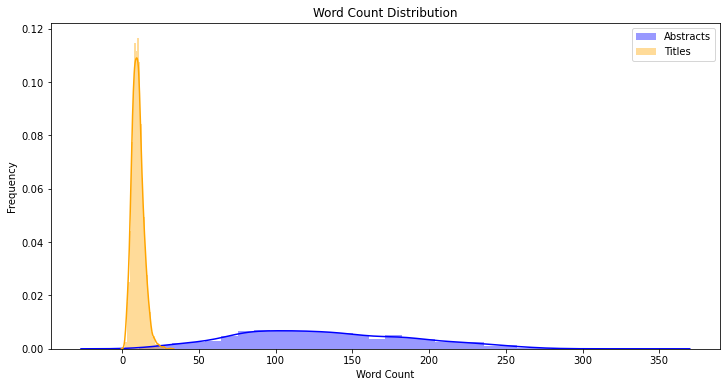

In [27]:
import seaborn as sns

# Calculate word counts
eval_df['abstract_word_count'] = eval_df['input_text'].apply(lambda x: len(x.split()))
eval_df['title_word_count'] = eval_df['target_text'].apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(12, 6))
sns.distplot(eval_df['abstract_word_count'], bins=30, kde=True, color='blue', label='Abstracts')
sns.distplot(eval_df['title_word_count'], bins=30, kde=True, color='orange', label='Titles')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [32]:
titles = []
abstracts = []
years = []
categories = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(category_map.keys())).flatten()

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    try:
        year = int(paper_dict.get('journal-ref')[-4:])
        if category in paper_categories and 2010 < year < 2021:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract').replace("\n", ""))
            years.append(year)
            categories.append(category)
    except:
        pass 

print(len(titles), len(abstracts), len(years), len(categories))


21592 21592 21592 21592


In [33]:
# Create DataFrame
df = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'year': years,
    'category': categories
})

# Map categories to their full names
df['category_full'] = df['category'].map(category_map)

# Aggregate counts by year and category
year_categories = df.groupby(['year', 'category_full']).size().unstack(fill_value=0)

# Transform the DataFrame for visualization
top_n = 10  # Define how many top categories you want
top_categories = year_categories.sum().sort_values(ascending=False).head(top_n).index.tolist()

# Filter the DataFrame to only include top categories
df1 = year_categories[top_categories]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['year'])
df2.columns = ['year', 'category', 'count']

# Visualize using plotly.express
import plotly.express as px

fig = px.line(df2, x="year", y="count", color='category', title='Top Categories Counts Over Years')
fig.show()


In [37]:
titles = []
abstracts = []
years = []
categories = []
authors_list = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(category_map.keys())).flatten()

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    try:
        year = int(paper_dict.get('journal-ref')[-4:])
        if category in paper_categories and 2010 < year < 2021:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract').replace("\n", ""))
            years.append(year)
            categories.append(category)
            authors_list.append(paper_dict.get('authors'))  # Assuming 'authors' is the correct key
    except:
        pass 

print(len(titles), len(abstracts), len(years), len(categories), len(authors_list))


21592 21592 21592 21592 21592


In [38]:
# Create DataFrame
df = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'year': years,
    'category': categories,
    'author': authors_list  # Ensure authors are included
})

# Explode the DataFrame to handle multiple authors per paper if necessary
df = df.explode('author')

# Aggregate counts by year and author
year_authors = df.groupby(['year', 'author']).size().unstack(fill_value=0)

# Transform the DataFrame for visualization
top_n = 10  # Define how many top authors you want
top_authors = year_authors.sum().sort_values(ascending=False).head(top_n).index.tolist()

# Filter the DataFrame to only include top authors
df1 = year_authors[top_authors]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['year'])
df2.columns = ['year', 'author', 'count']

# Visualize using plotly.express
import plotly.express as px

fig = px.line(df2, x="year", y="count", color='author', title='Top Authors Counts Over Years', width=1600, height=600)
fig.show()
